In [21]:
import pandas as pd
import numpy as np

In [22]:
df = pd.read_csv('../data/01_raw/data_claims.csv',sep=';')
df.head()

,Claim_ID,Policy_ID,Accident_Date,Report_Date,Payment_Date,Indemnity
0,1,31082,2016-09-12,2016-09-21,2017-07-03,83
1,2,61275,2017-11-20,2018-01-03,2018-02-02,71
2,3,72257,2013-06-10,2013-06-25,2013-07-15,115
3,4,73111,2013-09-17,2013-10-05,2018-09-20,67
4,5,84755,2017-06-30,2017-07-12,2017-09-30,122


In [23]:
df['Accident_Date'] = pd.to_datetime(df['Accident_Date'])
df['Payment_Date'] = pd.to_datetime(df['Payment_Date'])

In [24]:
df['Accident_Date'] = df['Accident_Date'].dt.to_period(freq='Y')
df['Payment_Date'] = df['Payment_Date'].dt.to_period(freq='Y')

In [25]:
df['Dev'] = df['Payment_Date'].astype(int) - df['Accident_Date'].astype(int)
df_agg = df.groupby(['Accident_Date','Dev']).agg({'Indemnity':'sum'}).reset_index()

In [26]:
triangle = df_agg.pivot(index='Accident_Date', columns='Dev', values='Indemnity')
triangle

Dev,0,1,2,3,4,5
Accident_Date,,,,,,
2013,118066.0,25877.0,12392.0,9743.0,8599.0,8977.0
2014,119961.0,26543.0,13813.0,11509.0,10339.0,NaN
2015,108140.0,27975.0,18551.0,14250.0,NaN,NaN
2016,107660.0,34826.0,19814.0,NaN,NaN,NaN
2017,112042.0,51641.0,NaN,NaN,NaN,NaN
2018,133511.0,NaN,NaN,NaN,NaN,NaN


In [27]:
accumulate = triangle.cumsum(axis=1)
accumulate

Dev,0,1,2,3,4,5
Accident_Date,,,,,,
2013,118066.0,143943.0,156335.0,166078.0,174677.0,183654.0
2014,119961.0,146504.0,160317.0,171826.0,182165.0,NaN
2015,108140.0,136115.0,154666.0,168916.0,NaN,NaN
2016,107660.0,142486.0,162300.0,NaN,NaN,NaN
2017,112042.0,163683.0,NaN,NaN,NaN,NaN
2018,133511.0,NaN,NaN,NaN,NaN,NaN


In [28]:
n = len(accumulate)-1

In [29]:
LDFs = np.ones(n)
for i in range(n):
	SumDev = pd.Series(accumulate[i][:n-i]).sum(skipna=True)
	SumDevNext = pd.Series(accumulate[min(i+1,n)][:n-i]).sum(skipna=True)
	LDFs[i] = SumDevNext/SumDev

In [30]:
CDFs = np.ones(n+1) #fix last value as 1.
for i in range(n):
	CDFs[i] = np.prod(LDFs[i:n])

In [31]:
payment_pattern = pd.DataFrame(data=np.reciprocal(CDFs),columns=['Cum'])
#First value of diff() is always NaN
payment_pattern['Incr'] = payment_pattern['Cum'].diff().fillna(payment_pattern['Cum'])

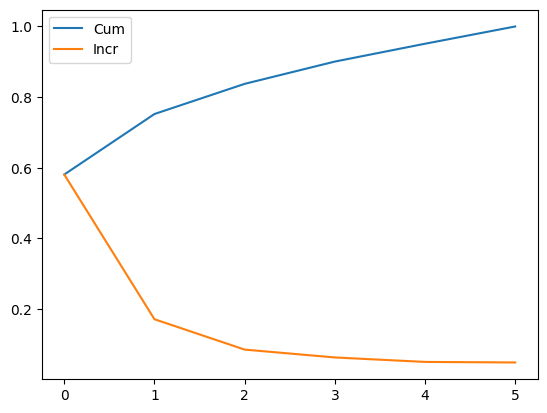

In [32]:
import matplotlib.pyplot as plt
payment_pattern.plot()
plt.show()

In [35]:
diagonal = np.diag(np.flipud(accumulate))
payments = pd.Series(data=diagonal)
ultimate = np.dot(CDFs, payments)
reserve = ultimate - np.sum(payments)
print(reserve.round(2))

209718.35
